# **Import section and dataset opening**

In [1]:
!pip install pandas

In [2]:
from google.colab import drive
import pandas as pd
import os
import shutil
import tensorflow as tf
import keras as K
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional, Input, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
df = pd.read_csv("https://github.com/Beshoy22/park_rev/raw/main/parkReviews.csv", encoding_errors='ignore')

# **General info**

In [4]:
df.shape

(42656, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


**Handling missing values**

I decided to highlight rows containing missing values, to drop them later on the program. In particular I decided to check them in the 'Year_Month' due to the difficulty in filling missing dates.

In [6]:
# Create a boolean mask to identify rows containing 'missing'
mask = df['Year_Month'] != 'missing'

# Filter the DataFrame using the mask
df = df[mask]

# **Target label**

**Identification of target label**

In [7]:
# Separate the data into two sets based on input types
X = df[['Year_Month', 'Branch', 'Reviewer_Location', 'Review_Text']]
y = df['Rating']

**Check if unbalanced classes**

Thanks to a plot of the distribution of the target classes, I am able to check if there is balance or not.

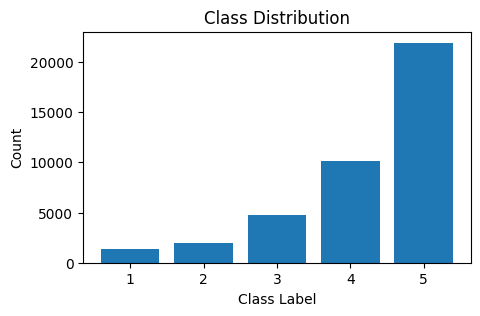

In [8]:
import matplotlib.pyplot as plt

# Calculate the class distribution
class_counts = y.value_counts()

# Plot the class distribution
plt.figure(figsize=(5, 3))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

**Undersampling due to unbalanced classes**

Since the classes are unbalanced, the output of my original model was almost always 5 (the largest class lable); this caused underfitting, so I decided to downsample the entire dataset, losing some information, but at least creating a balanced target label. Thanks to the RandomUnderSample I am able to reduce the dimension of the dataset at random.
Beforedownsampling classes, i compared two different types of resampling: the first one performed a reshaping of the fifth class in the sense that it would normalize with the same intances as the forth one. However the best model

In [9]:
from imblearn.under_sampling import RandomUnderSampler

# Create an instance of RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Perform undersampling on your feature and target data
X_resampled, y_resampled = rus.fit_resample(X, y)

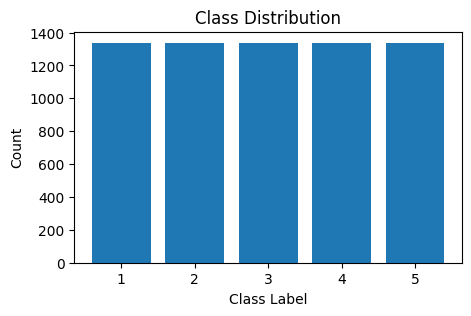

In [10]:
# Calculate the class distribution
class_counts = y_resampled.value_counts()

# Plot the class distribution
plt.figure(figsize=(5, 3))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

The resampling produced a new matrix composed of 5 columns (possible rating values) and 1400 rows for each of the 5 columns. the final shape is (7000 x 5).

**Encoding categorical columns**

For 'Branch' and 'Reviewer_Location' features I decided to use the LabelEncoder that transform the categorical values into numerical ones.

In [11]:
# Create instance for LabelEncoder
encoder = LabelEncoder()

# Encode the categorical columns
X_resampled['Branch'] = encoder.fit_transform(X_resampled['Branch'])
X_resampled['Reviewer_Location'] = encoder.fit_transform(X_resampled['Reviewer_Location'])

**Splitting Year and Month column to scale them**

For an easyer handling of the date feature, I decided to split the 'Year_Month' column into two separate columns: one for the year and the other for the identification of the month.

In [12]:
# Convert the date column to datetime format
X_resampled['Year_Month'] = pd.to_datetime(X_resampled['Year_Month'], format='%Y/%m')

# Extract month and year components
X_resampled['Month'] = X_resampled['Year_Month'].dt.month
X_resampled['Year'] = X_resampled['Year_Month'].dt.year

# Drop the original date column
X_resampled.drop('Year_Month', axis=1, inplace=True)

**Scaling numerical features**

After the splitting, I am now able to scale the numerical values using a MinMaxScaler. But before, I have to change the type of year and month values (from str to int).

In [13]:
# Changing type of numerical columns (before read as str)
X_resampled['Year'] = X_resampled['Year'].astype(int)
X_resampled['Month'] = X_resampled['Month'].astype(int)

In [14]:
# Create an instance of the MinMaxScaler
scaler = MinMaxScaler()

# Define the columns to be scaled
numerical_columns = ['Year', 'Month']

# Fit and transform the selected columns
X_resampled[numerical_columns] = scaler.fit_transform(X_resampled[numerical_columns])

# **Dividing the X set into two subsets**

Since I decided to combine two different models, I have to define two different inputs for both models. Splitting one more time the dataset allows me to keep a matrix with features 'Year', 'Month', 'Branch', 'Reviewer_Location' for the Multi Layer Perceptron; and the 'Review_Text' column for the RNN architecture.

In [15]:
# Separate the data into two sets based on input types
features = X_resampled[['Year', 'Month', 'Branch', 'Reviewer_Location']]
text_data = X_resampled['Review_Text']

# **MLP architecture**

**Data splitting**

Defining the test and train sets for the smaller dataset called 'features'

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, y_resampled, test_size=0.2, random_state=42)

# Print the shape and type of X_train
print(f"X_train.shape: {X_train.shape}")

X_train.shape: (5352, 4)


*ANSWER TO QUESTION 1*

The X_train.shape is the input of the first architecture, which is the Multi Layer Perceptron: a matrix of size (5352, 4).

The target variable needs to be transformed from numerical to categorical and also to be alligned with indexing.

In [17]:
# Convert target variable to categorical
y_train_encoded = to_categorical(y_train - 1)  # Subtract 1 to align with zero-based indexing
y_test_encoded = to_categorical(y_test - 1)

# Print the number of classes
num_classes = y_train_encoded.shape[1]
print("Number of classes:", num_classes)

Number of classes: 5


**Defining MLP model**

In [18]:
# Define MLP model
mlp_input = Input(4)
mlp_hidden = Dense(256, activation='relu')(mlp_input)
mlp_output = Dense(128, activation='relu')(mlp_hidden)
mlp_model = Model(inputs=mlp_input, outputs=mlp_output)

In [19]:
mlp_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 256)               1280      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
Total params: 34,176
Trainable params: 34,176
Non-trainable params: 0
_________________________________________________________________


In [20]:
mlp_output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_1')>

*ANSWER TO QUESTION 2*

The output layer of the MLP is a vector of probabilities, in which all instances are assign a probability for all classes.

# **RNN architecture**

**Tokenization**

Tokenization applied on the text reviews present in the subset of the dataset 'text_data' previously defined. Also, the sequence method converts a list of texts (text_data) into a list of sequences, where each sequence represents the original text converted into a sequence of integers. Each integer corresponds to the index of a word in the tokenizer's vocabulary.

In [21]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)

Padding the sequences is often necessary when working with text data, as models typically expect inputs of fixed dimensions. By padding the sequences, you ensure that all inputs have the same length, allowing them to be processed by models like recurrent neural networks (RNNs)

In [22]:
# Pad the sequences to have a consistent length
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

**Data splitting**

Defining train and test sets for the smaller dataset 'text_data'

In [23]:
# Split the data into training and testing sets
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(padded_sequences, y_resampled, test_size=0.2, random_state=42)

# Print the shape and type of X_train
print(f"X_train_t.shape: {X_train_t.shape}")

X_train_t.shape: (5352, 2587)


*ANSWER TO QUESTION 1*

The input of the RNN model is a sequence of vectors of the same lenght (thanks to the padding), in which each vector represents a token in the text.

**Defining RNN model**

I decided to use the Bidirectional LSTM: after triyng different models (GRU or LSTM), it turns out this was the best option.

In [24]:
# Define RNN model
rnn_input = Input(2587)
rnn_embedded = Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_sequence_length)(rnn_input)
rnn_gru = Bidirectional(GRU(128, dropout= 0.4, recurrent_dropout= 0.4))(rnn_embedded)
rnn_model = Model(inputs=rnn_input, outputs=rnn_gru)

# **Concatenation of MLP and RNN**

Thanks to the concatenation layer I was able to perform a sort of merge between the two different architectures in the last layer of the Neural Network.

In [25]:
# Concatenate the outputs of the MLP and RNN layers
concatenated = tf.concat([mlp_output, rnn_gru], axis=1)

# Output layer
output = Dense(num_classes, activation='softmax')(concatenated)

# Create the combined model
combined_model = Model(inputs=[mlp_input, rnn_input], outputs=output)

*ANSWER TO QUESTION 2*

The final output of the model concatenated is a dense layer in which the Softmax is used as activation function.

*ANSWER TO QUESTION 4*

Before compiling the model, I defined some hyperparameters such as the early stopping, that allows me to keep a large number of epochs but stopping iterations when convergence is reached; and the optimizer Adam with a very small learning rate: after different trials, it was better to reduce the learning rate, since it is verified an overfitting.

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [27]:
optimizer = Adam(learning_rate=0.001)

*ANSWER TO QUESTION 3*

In the compilation model I choose as Loss function the categorical crossentropy since I am not working with One Hot vectors. Wgile in the hidden layers I used as activation function the SReLu for the MLP architecture.

In [ ]:
combined_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Convert y_train and y_train_t to one-hot encoded vectors
y_train_encoded = to_categorical(y_train - 1)
y_train_t_encoded = to_categorical(y_train_t - 1)

# Convert y_test and y_test_t to one-hot encoded vectors
y_test_encoded = to_categorical(y_test - 1)
y_test_t_encoded = to_categorical(y_test_t - 1)

# Convert input data to numpy arrays if needed
X_train = np.array(X_train)
X_train_t = np.array(X_train_t)
X_test = np.array(X_test)
X_test_t = np.array(X_test_t)

# Train the combined model
combined_model.fit([X_train, X_train_t], y_train_encoded,
          epochs=10,
          batch_size=32,
          callbacks=[callback],
          validation_data=([X_test, X_test_t], y_test_encoded))


Epoch 1/10
 35/168 [=====>........................] - ETA: 46:50 - loss: 1.8421 - accuracy: 0.1982

Prediction of the combined model.

In [ ]:
pred_combined = combined_model.predict([X_test, X_test_t])
print(f"pred_combined.shape:{pred_combined.shape}")
print(pred_combined)

Since the output is a vector of probablities, I want to transform it into categorical predictions.

In [ ]:
# getting categorical prediction
print(pred_combined[0])
cat_pred_combined = np.argmax(pred_combined, axis=1)
print(f"cat_pred_combined.shape:{cat_pred_combined.shape}")
print(cat_pred_combined[0])

Due to indexing matters, I need to shift all outputs of one, using a dictionary.

In [ ]:
mapping = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}

y_test_mapped = np.array([mapping[int(value)] for value in cat_pred_combined], dtype=int)

print(y_test_mapped)

# **Results and Hyperparameters**

**Plotting confusion matrix**

*ANSWER TO QUESTION 6*

Since I have rebalanced the label classes, the 'accuracy' is the best evaluation score that I can use.
The high value of accuracy, increasing at each epoch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have the true labels and predicted labels
true_labels = y_test
predicted_labels = y_test_mapped

# Get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [1,2,3,4,5], rotation=45)
plt.yticks(tick_marks, [1,2,3,4,5])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Display the values inside the confusion matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


*ANSWER TO QUESTION 5*

It turns out that my model is very overfitted: the accuracy score is too high, in fact the model is learning the patterns striclty related to my specific dataset. After checking performances, I decided to change some hyperparameters in the model to contrast overfitting:
- Dropout added in the LSTM layer
- Number of neurons: 128 for the LSTM
- Token embedding dimension: augmented to a larger number (it was 100 before)
- Number of epochs